# Computational Illustrations of the Ising Model

# 1D Ising Model and Metropolis Algorithm

### Problem Restatement: 
The problem is to explore the thermal properties of magnets, applying the Ising model in 1 and 2 dimensions where, assuming no external magnetic fields, N fixed magnetic dipoles, each of +1/2 or -1/2 spin and with exchange energy J, align or anti-align in lattices with temperature T.

### Description of Numerical Method Used: 
The Metropolis Algorithm is Monte Carlo Method aided with von Neumann rejection technique applied to a Boltzman distribution under a fixed temperature and initial spin configuration. By running and algorithm one can achieve equilibriation, after which continued running generates statistical fluctuations that can be used to deduce thermodynamic quantities including magnetization, specific heat capacity, and susceptibility. We start by defining functions to generate initial spin configuation, to implement the algorithm, to calculate energy of a configuration, and to calculate magnetization of a configuration.

In [1]:
%matplotlib inline
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from numba import jit
import copy
from __future__ import division

In [2]:
def initialstate(N):   
    
    state = 2*np.random.randint(1, size=(1,N)) + 1 # cold start
    #state = 2*np.random.randint(2, size=(1,N)) - 1 # hot start
    state = np.squeeze(state)
    return state

def mcmove(config, beta):  # Monte Carlo Movement

    for i in range(N):
        b = np.random.randint(N)
        s =  config[b]        
        nb = config[(b+1)%N] + config[(b-1)%N] # Only nearest neighbors are considered ##periodic boundary condition
        cost = 2*s*nb*J
        if cost < 0:
            s *= -1
        elif rand() < np.exp(-cost*beta):
            s *= -1
        config[b] = s
    
    return config

def calcEnergy(config):
    energy = 0
    for i in range(N):
        S = config[i]
        nb = config[(i+1)%N] + config[(i-1)%N]
        energy += -nb*S
    return energy/2.    #Avoid multiple counting

def calcMag(config):
    mag = np.sum(config)
    return mag

Then the parameter of the system should be set:

In [4]:
## change the parameter below if you want to simulate a smaller system
if __name__ == "__main__":
    nt      = 2**6       # number of temperature points
    N       = 2**6       # size of the lattice, N
    J = 1   # use -1 if it is a anti-ferromagnet

### Equilibration Simulation
We now simuluate the equilibration of an Ising system when connected to a heat bath of tempearture Temp. 
eqmove function is just mcmove function adjusted to illustrate the process of equilibration.

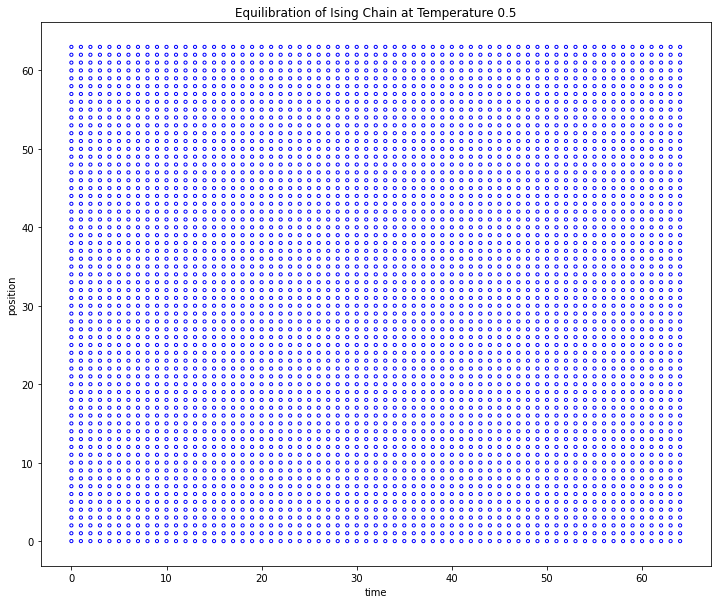

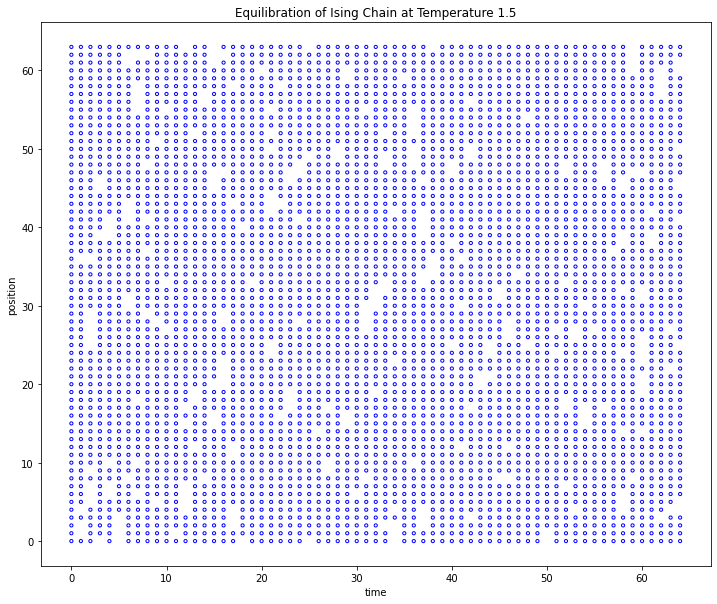

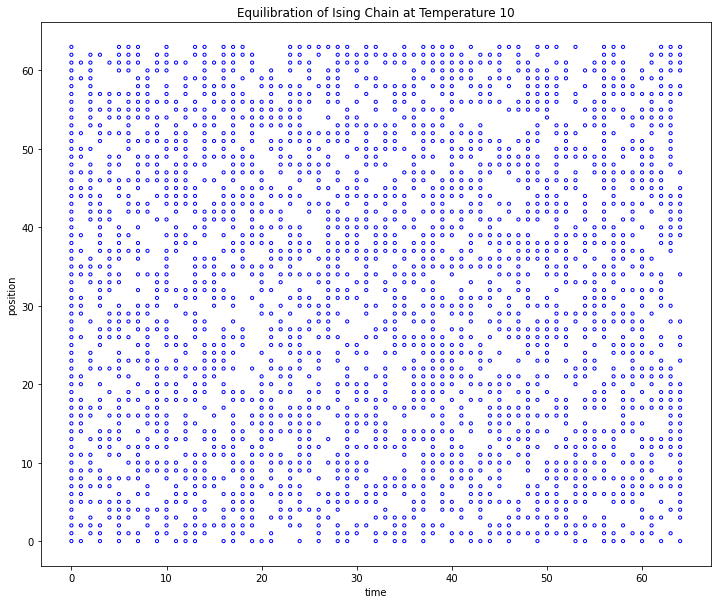

In [5]:
def eqmove(config, beta): 

    config = copy.deepcopy(config) # this is to prevent overwriting when appending list
    for i in range(N):
        b = np.random.randint(N)
        s =  config[b]        
        nb = config[(b+1)%N] + config[(b-1)%N] # Only nearest neighbors are considered ##periodic boundary condition
        cost = 2*s*nb*J
        if cost < 0:
            s *= -1
        elif rand() < np.exp(-cost*beta):
            s *= -1
        config[b] = s
    
    return config

def sim(Temp):
   
   start = initialstate(N)
   config_list = [start]

   for n in range(2**6):
      config = eqmove(start,1/Temp)
      config_list.append(config)

   plt.figure(figsize=(12,10))
   plt.title(f"Equilibration of Ising Chain at Temperature {Temp}")
   plt.xlabel("time"); plt.ylabel("position")
   for t in np.arange(len(config_list)):
      for spin in np.arange(len(config_list[t])):
         if config_list[t][spin] == 1:
            plt.scatter(t,spin,s=10,c="none",edgecolor="b",marker="o")

if __name__ == "__main__":
    
    sim(0.5)
    sim(1.5)
    sim(10)

Critical Analysis: 
- There are high fluctuations at higher tempearture, as shown convincingly in the graphs above
- There are higher fluctuations with less number of particles
- There are evidences for spontaneous fluctuation of large number of spins, especially at higher tempearture (kb*T), as can be seen in the graph with T = 10 above.
- At thermal equilibrium, there are still dynamic energy exchange, which determines the thermodynamic quantities that will be examined soon
- Systems of with large number of particles and low tempearture, such as those exemplified in graph with T = 0.5, consumes a long time to equilibrate.


### Average Domain Size

Description of Numerical Method Used: We now define a function avDomain calculate the average size of domain. 

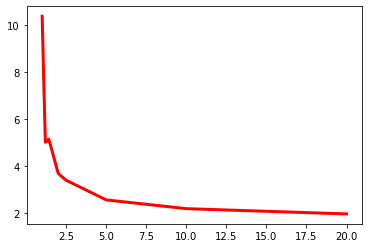

In [6]:
def avDomain(config,beta):
    
    for l in range(2**8):
        mcmove(config,beta)
    
    size_list = []
    k = 0
    while k < N:
        if config[k] * config[(k-1)%N] == 1:
            count = 0
            for i in range(N):
                if config[(k+i)%N] == config[k]:
                    count +=1
                else:
                    size_list.append(count)
                    break
        k += 1
    
    avDS = np.mean(size_list)
    
    return avDS

if __name__ == "__main__":
    
    N = 2**6
    nTrialDS = 10
    

    Tlist = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 2.5, 5.0, 10.0, 20.0]
    avDSlist = []
    for t in Tlist:
        avDS = 0.0
        for s in range(nTrialDS):
            config = initialstate(N)
            avDS += avDomain(config,1/t)
        avDSlist.append(avDS/10)

    plt.figure()
    plt.plot(Tlist, avDSlist, '-r', lw=3.0)
    plt.show()


Critical Analysis:
- There's a clear and swift decreasing trend due to the quick loss of macroscopic magnetic order that eliminates the alignment of spins. The more the spins the align, as in low-temperature conditions, the greater the average domain size.
- If the exchange energy is changed to -1 as for an antiferromagnet, the trend reverses: it increases quickly in low temperature and then became persistently high. This is because antiferromagnetic material tends to have all spins antiparallel in low energy status.

### Temperature Dependence of Thermodynamic Quantities

Next, we can extend the program to calculate the internal energy, magnetization, specific heat, and susceptibility of the system using the code below. Three trials are averaged to reduce statistical fluctuation. Before the calculation, the parameters should be set.

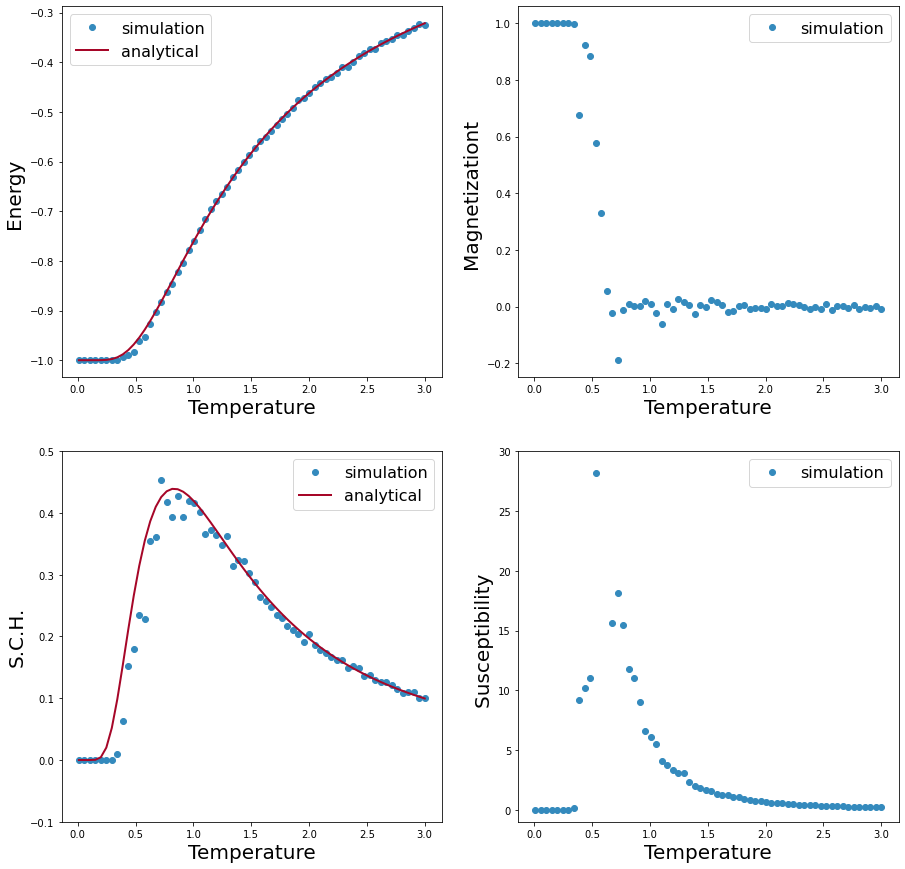

In [7]:
if __name__ == "__main__":
        
    eqSteps = 2**8       # number of MC sweeps for equilibration
    mcSteps = 2**8       # number of MC sweeps for calculation

    n1, n2  = 1.0/(mcSteps*N*1), 1.0/(mcSteps*mcSteps*N*1)  

    T=np.linspace(.01, 3.0, nt)

    nTrial = 10

    Energy       = np.zeros((nt,nTrial));   Magnetization  = np.zeros((nt,nTrial))
    SpecificHeat = np.zeros((nt,nTrial));   Susceptibility = np.zeros((nt,nTrial))

    for n in range(nTrial):

        for m in range(len(T)):
            
            config = initialstate(N)
            iT=1.0/T[m]; iT2=iT*iT; # beta = 1/(k_B*T)
            
            for l in range(eqSteps):         # equilibrate
                mcmove(config, iT)           # Monte Carlo moves

            #Calculate quantities post equilibriation
            E1 = M1 = E2 = M2 = 0
            for i in range(mcSteps):
                mcmove(config, iT)           
                Ene = calcEnergy(config)     # calculate the energy
                Mag = calcMag(config)        # calculate the magnetisation

                E1 = E1 + Ene                 #Cumulative energy 
                M1 = M1 + Mag
                M2 = M2 + Mag*Mag 
                E2 = E2 + Ene*Ene

                Energy[m,n]         = n1*E1     #Weighing for MC averages. 
                Magnetization[m,n]  = n1*M1
                SpecificHeat[m,n]   = (n1*E2 - n2*E1*E1)*iT2
                Susceptibility[m,n] = (n1*M2 - n2*M1*M1)*iT2 
    
    Energy = np.mean(Energy,axis=1)
    Magnetization = np.mean(Magnetization,axis=1)
    SpecificHeat = np.mean(SpecificHeat,axis=1)
    Susceptibility = np.mean(Susceptibility,axis=1)
  
    f = plt.figure(figsize=(15, 15)); # plot the calculated values    

    sp =  f.add_subplot(2,2,1);
    plt.plot(T, Energy, 'o', color="#348ABD", label='simulation');
    plt.plot(T, -np.tanh(J/T), color="#A60628", lw=2,label='analytical')
    plt.xlabel("Temperature", fontsize=20);
    plt.ylabel("Energy ", fontsize=20); plt.legend(fontsize=16)


    sp =  f.add_subplot(2,2,2);
    plt.plot(T, Magnetization, 'o', color="#348ABD", label='simulation');
    plt.xlabel("Temperature", fontsize=20); #plt.ylim([-10, -2])
    plt.ylabel("Magnetizationt ", fontsize=20);  plt.legend(fontsize=16)

    sp =  f.add_subplot(2,2,3);
    plt.plot(T, SpecificHeat, 'o', color="#348ABD", label='simulation');
    plt.plot(T, (1.0/T**2)*(np.cosh(1.0/T))**(-2), color="#A60628", lw=2,label='analytical')
    plt.xlabel("Temperature", fontsize=20); plt.ylim([-0.1, 0.5])
    plt.ylabel("S.C.H.", fontsize=20); plt.legend(fontsize=16)


    sp =  f.add_subplot(2,2,4);
    plt.plot(T, Susceptibility, 'o', color="#348ABD", label='simulation');
    plt.xlabel("Temperature", fontsize=20); plt.ylim([-1, 30])
    plt.ylabel("Susceptibility ", fontsize=20);  plt.legend(fontsize=16)   

Critical Analysis:
- At very low tempearture (less than one kelvin), the energy is very low
- At low tempearture (less than around 0.8 K, the curie temperature in this case), there's a dominant spin and therefore a magnetization of 1. However, above this critical tempearture, the macroscopic order of the system quickly disappears, and the magnetic dipoles cancel each other to generate a overall spontaneous magnetization near zero.
- At the critical temperature, the specific heat capacity peaks, potentially due to the great amoutn of energy needed to break/create the magnetic domains.
- As tempearture approaches the curie temperature from above, the susceptibility of the material approaches infinity, corresponding to the Curie–Weiss law.

- It can be shown (by changing the initialstate function in the beginning of this notebook) that changing the initial condition has limited effect on the simulated behaviors.



# 2D Ising Model

Now we can generalize the model into 2D. The initial state now is a N*N configuration. The boundary is still periodic. The energy is now divided by 2.

In [10]:
def initialstate2(N):   
    state = np.random.randint(1, size=(N,N))+1  ##Cold start
    #state = 2*np.random.randint(2, size=(N,N))-1  ##Hot start
    return state

def mcmove2(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb*J
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config


def calcEnergy2(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/2.


def calcMag2(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

Similarly, we set the parameters for simulation of 2D Ising Model.

In [9]:
if __name__ == "__main__": 
    
    nt      = 2**6         #  number of temperature points
    N       = 6         #  size of the lattice, N x N
    eqSteps = 1024       #  number of MC sweeps for equilibration
    mcSteps = 1024       #  number of MC sweeps for calculation
    J = 1
    nTrial2 = 3

    T       = np.linspace(0.1, 5.0, nt); 
    E,M,C,X = np.zeros((nt,nTrial2)), np.zeros((nt,nTrial2)), np.zeros((nt,nTrial2)), np.zeros((nt,nTrial2))
    n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
                                                 

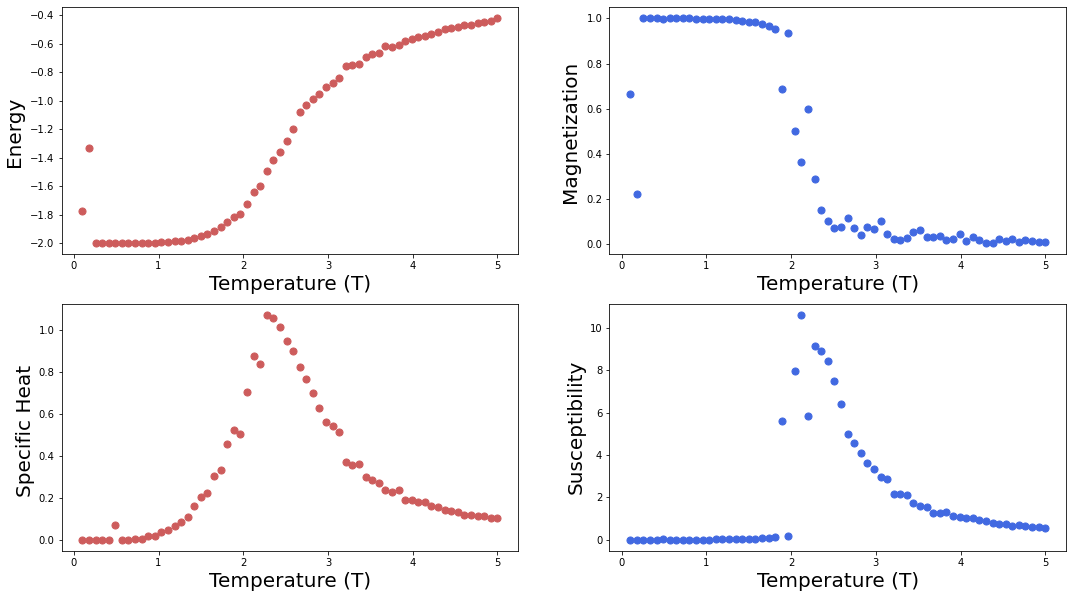

In [11]:
    for n in range(nTrial2):
        
        for tt in range(nt):
            E1 = M1 = E2 = M2 = 0
            config = initialstate2(N)
            iT=1.0/T[tt]; iT2=iT*iT
            
            for i in range(eqSteps):         # equilibrate
                mcmove2(config, iT)           # Monte Carlo moves

            for i in range(mcSteps):
                mcmove2(config, iT)           
                Ene = calcEnergy2(config)     # calculate the energy
                Mag = calcMag2(config)        # calculate the magnetisation

                E1 = E1 + Ene
                M1 = M1 + Mag
                M2 = M2 + Mag*Mag 
                E2 = E2 + Ene*Ene

            E[tt,n] = n1*E1
            M[tt,n] = n1*M1
            C[tt,n] = (n1*E2 - n2*E1*E1)*iT2
            X[tt,n] = (n1*M2 - n2*M1*M1)*iT

    E = np.mean(E,axis=1)    
    M = np.mean(abs(M),axis=1) 
    C = np.mean(C,axis=1)  
    X = np.mean(X,axis=1)   

    f2 = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f2.add_subplot(2, 2, 1 )
    plt.scatter(T, E, s=50, marker='o', color='IndianRed')
    plt.xlabel("Temperature (T)", fontsize=20)
    plt.ylabel("Energy ", fontsize=20);         plt.axis('tight')

    sp =  f2.add_subplot(2, 2, 2 )
    plt.scatter(T, M, s=50, marker='o', color='RoyalBlue')
    plt.xlabel("Temperature (T)", fontsize=20); 
    plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')

    sp =  f2.add_subplot(2, 2, 3 )
    plt.scatter(T, C, s=50, marker='o', color='IndianRed')
    plt.xlabel("Temperature (T)", fontsize=20);  
    plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

    sp =  f2.add_subplot(2, 2, 4 )
    plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
    plt.xlabel("Temperature (T)", fontsize=20); 
    plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');          

Critical Analysis: It can be inferred that the temperature dependence of average energy, magnetization, specific heat, and susceptiblity is qualitatively the same as in 1D condition

Description of Numerical Method Used: Next, we define a class to simulate hot-start 2D Ising Model equilibration process. Three temperature are tested: 0.3 (below Curie Tempearture), 10 (above curie temperature), and 2.5 (just about the curie tempearture by eye observation)

/var/folders/zz/3h7st6qx04l6zhbs47frz3k9zwf0z7/T/ipykernel_11563/3364824063.py:45: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu)


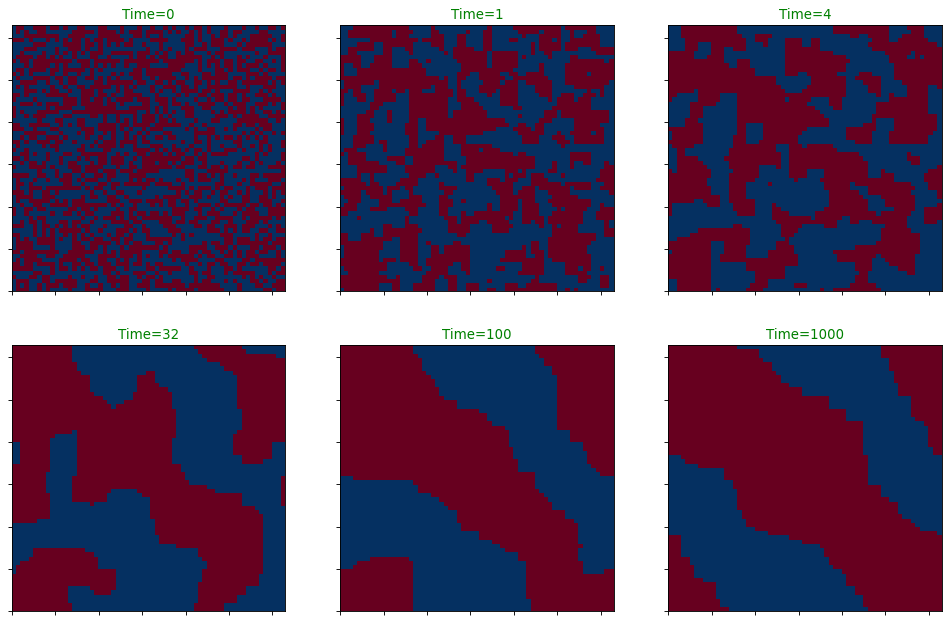

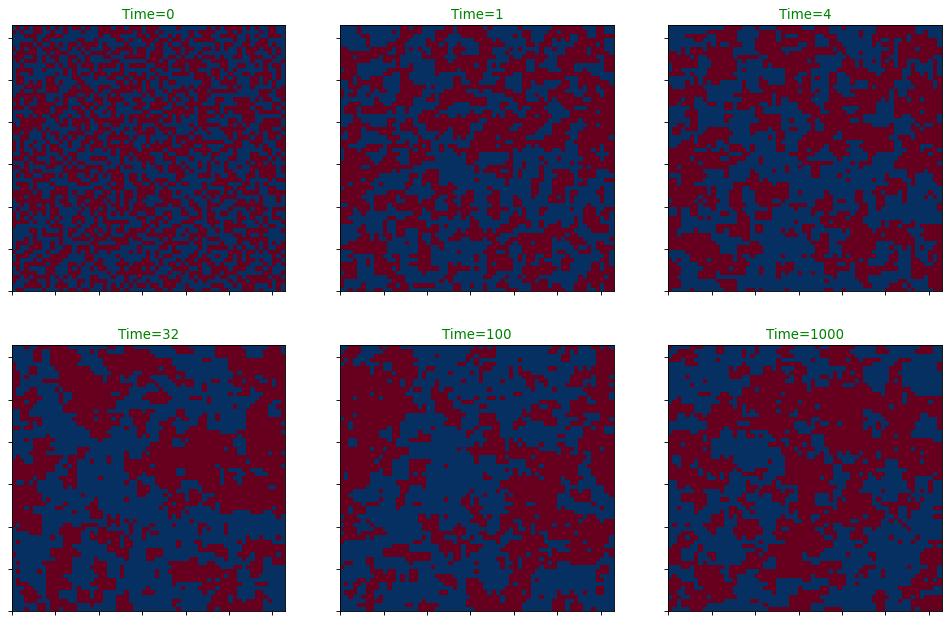

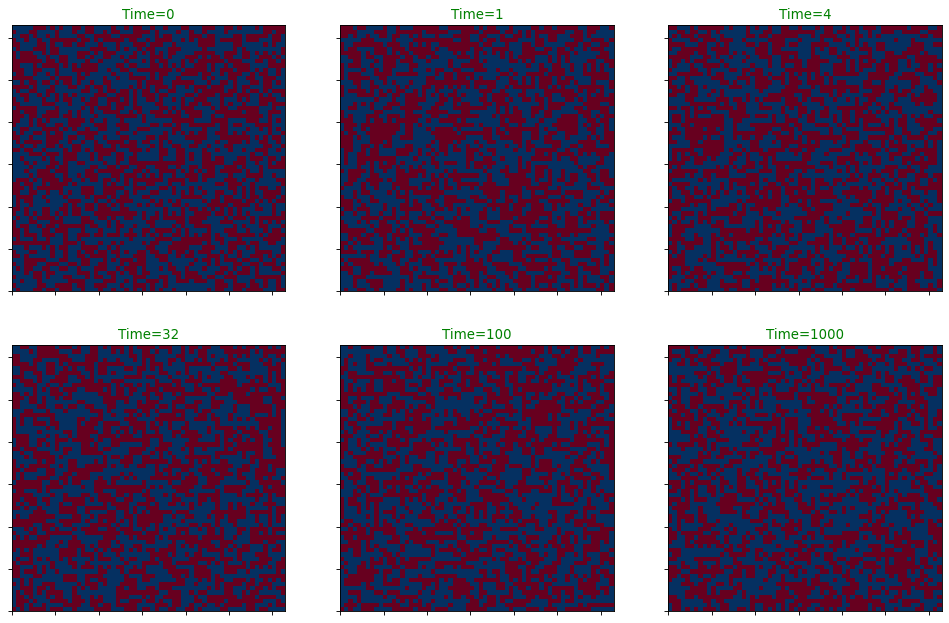

In [8]:
class Ising2D():
    ''' Simulating the Ising model '''    
    ## monte carlo moves
    def mcmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    s =  config[a, b]
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    cost = 2*s*nb
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    
    def simulate(self,Temp):   
        ''' This module simulates the Ising model'''
        N      = 64        # Initialse the lattice
        config = initialstate2(N)    # Change cold / hot start above
        f = plt.figure(figsize=(15, 15), dpi=80); 
        self.configPlot(f, config, 0, N, 1)
        
        msrmnt = 1001
        for i in range(msrmnt):
            self.mcmove(config, N, 1.0/Temp)
            if i == 1:       self.configPlot(f, config, i, N, 2)
            if i == 4:       self.configPlot(f, config, i, N, 3)
            if i == 32:      self.configPlot(f, config, i, N, 4)
            if i == 100:     self.configPlot(f, config, i, N, 5)
            if i == 1000:    self.configPlot(f, config, i, N, 6)
                 
                    
    def configPlot(self, f, config, i, N, n_):

        X, Y = np.meshgrid(range(N), range(N))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu)
        plt.title('Time=%d'%i, color = "g"); plt.axis('tight')    

rm = Ising2D()
rm.simulate(0.3)
rm.simulate(2.5)
rm.simulate(10)

Critical Analysis
- For temperature less than curie tempearture (first six graphs), the configuration eventually equilibrates into a dominance of one spin
- At the curie temperature, the system fluctutates with no clear dominance of any spin, and the fluctuation is of all scales.
- Above the curie temperature, the spin configuration is more disordered but more even - still there's no dominance of any spin, and the domains are even smaller. 


# 3D Ising Model

Description of Numerical Method Used: Generalization to 3D with N^3 spins: nearest-neighbor interaction now have six directions to go (left, right, front, back, above, below). Periodic boundary condition is maintained.

In [12]:
def initialstate3(N):   
    #state = np.random.randint(1, size=(N,N,N))+1  ##Cold start
    state = 2*np.random.randint(2, size=(N,N,N))-1  ##Hot start
    return state

def mcmove3(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
        for j in range(N):
            for k in range(N):
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    c = np.random.randint(0,N)
                    s =  config[a, b, c]
                    nb = config[(a+1)%N,b,c] + config[a,(b+1)%N,c] + config[(a-1)%N,b,c] + config[a,(b-1)%N,c] + config[a,b,(c+1)%N] + config[a,b,(c-1)%N]
                    cost = 2*s*nb*J
                    if cost < 0:
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b, c] = s
    return config

def calcEnergy3(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            for k in range(len(config)):
                S = config[i,j,k]
                nb = config[(i+1)%N,j,k] + config[i,(j+1)%N,k] + config[(i-1)%N,j,k] + config[i,(j-1)%N,k] + config[i,j,(k+1)%N] + config[i,j,(k-1)%N]
                energy += -nb*S
    return energy/2.

def calcMag3(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(np.sum(config))
    return mag

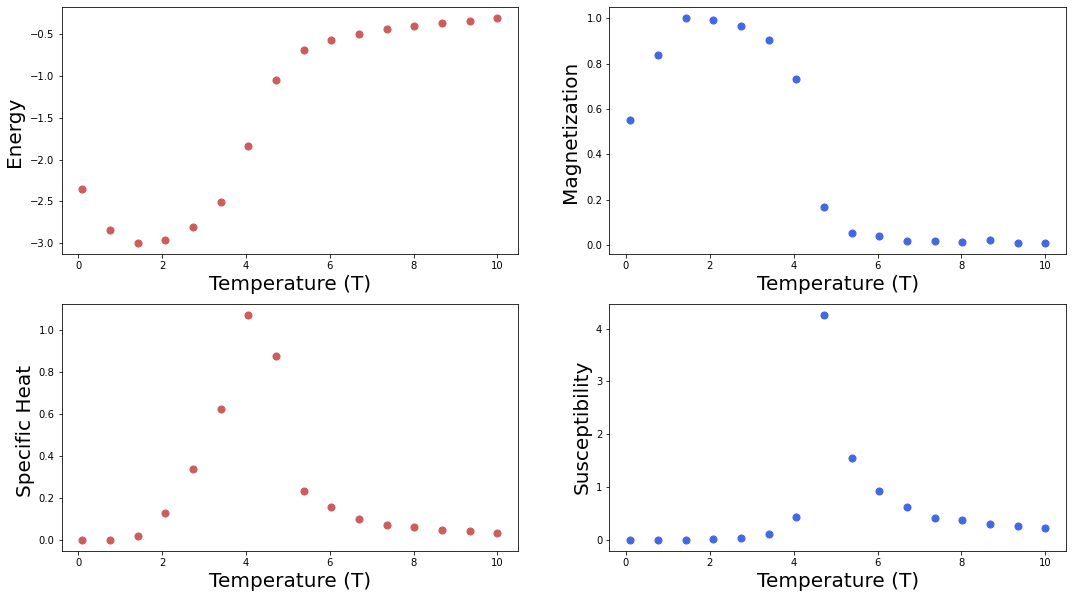

In [16]:
if __name__ == "__main__": 
    
    nt      = 2**4         #  number of temperature points
    N       = 5         #  size of the lattice, N x N
    eqSteps = 256       #  number of MC sweeps for equilibration
    mcSteps = 256       #  number of MC sweeps for calculation
    J = 1
    nTrial3 = 5

    T       = np.linspace(0.1, 10.0, nt); 
    E,M,C,X = np.zeros((nt,nTrial3)), np.zeros((nt,nTrial3)), np.zeros((nt,nTrial3)), np.zeros((nt,nTrial3))
    n1, n2  = 1.0/(mcSteps*N*N*N), 1.0/(mcSteps*mcSteps*N*N*N)    
   
    for n in range(nTrial3):
        
        for ttt in range(nt):
            E1 = M1 = E2 = M2 = 0
            config = initialstate3(N)
            iT=1.0/T[ttt]; iT2=iT*iT
            
            for i in range(eqSteps):         # equilibrate
                mcmove3(config, iT)           # Monte Carlo moves

            for i in range(mcSteps):
                mcmove3(config, iT)           
                Ene = calcEnergy3(config)     # calculate the energy
                Mag = calcMag3(config)        # calculate the magnetisation

                E1 = E1 + Ene
                M1 = M1 + Mag
                M2 = M2 + Mag*Mag 
                E2 = E2 + Ene*Ene

            E[ttt,n] = n1*E1
            M[ttt,n] = n1*M1
            C[ttt,n] = (n1*E2 - n2*E1*E1)*iT2
            X[ttt,n] = (n1*M2 - n2*M1*M1)*iT

    E = np.mean(E,axis=1)    
    M = np.mean(abs(M),axis=1) 
    C = np.mean(C,axis=1)  
    X = np.mean(X,axis=1)   

    f2 = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f2.add_subplot(2, 2, 1 )
    plt.scatter(T, E, s=50, marker='o', color='IndianRed')
    plt.xlabel("Temperature (T)", fontsize=20)
    plt.ylabel("Energy ", fontsize=20);         plt.axis('tight')

    sp =  f2.add_subplot(2, 2, 2 )
    plt.scatter(T, M, s=50, marker='o', color='RoyalBlue')
    plt.xlabel("Temperature (T)", fontsize=20); 
    plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight')

    sp =  f2.add_subplot(2, 2, 3 )
    plt.scatter(T, C, s=50, marker='o', color='IndianRed')
    plt.xlabel("Temperature (T)", fontsize=20);  
    plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

    sp =  f2.add_subplot(2, 2, 4 )
    plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
    plt.xlabel("Temperature (T)", fontsize=20); 
    plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');          

Critical Analysis: Again, it can be inferred that in 3D conditions, the temperature dependence of thermodynamic quantities are unchanged.

# Beyond Nearest Neighbor

The spin-spin (or dipole-dipole) interaction is now extended to the next-nearest neighbor to test the balance between precision and efficiency. Note the strength of interaction decreases with a power of 4 as distance between spins increases.

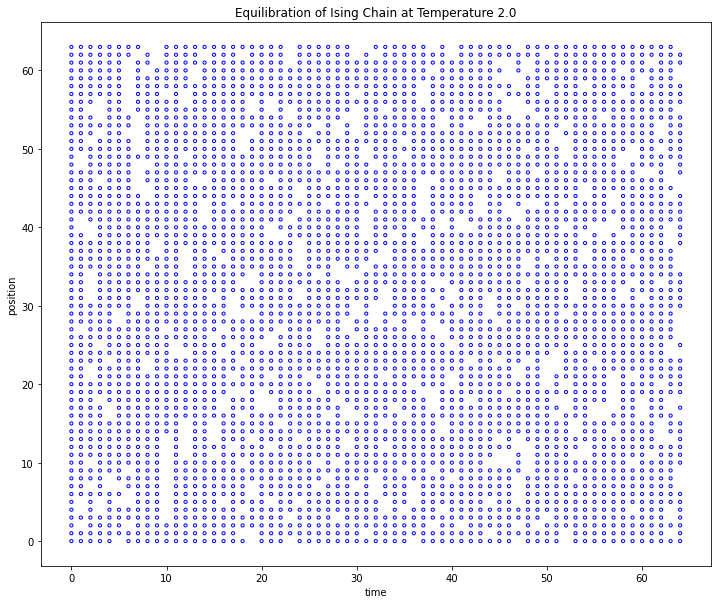

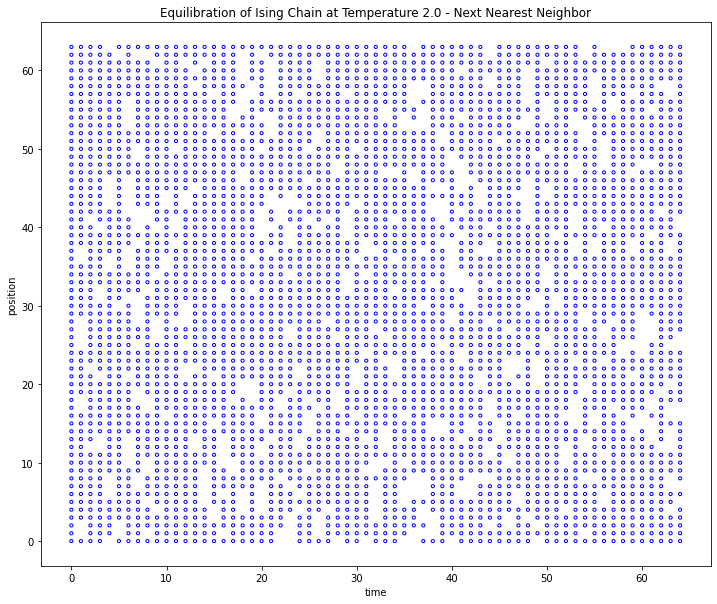

In [18]:
def nnbmove(config, beta): 

    config = copy.deepcopy(config) # this is to prevent overwriting when appending list
    for i in range(N):
        b = np.random.randint(N)
        s =  config[b]        
        nb = config[(b+1)%N] + config[(b-1)%N] # nearest neighbors
        nnb = config[(b+2)%N] + config[(b-2)%N]
        cost = 2*s*nb*J + 2*s*nb*J/16
        if cost < 0:
            s *= -1
        elif rand() < np.exp(-cost*beta):
            s *= -1
        config[b] = s
    
    return config

def sim_nnb(Temp):
   
   start = initialstate(N)
   config_list = [start]

   for n in range(2**6):
      config = eqmove(start,1/Temp)
      config_list.append(config)

   plt.figure(figsize=(12,10))
   plt.title(f"Equilibration of Ising Chain at Temperature {Temp} - Next Nearest Neighbor")
   plt.xlabel("time"); plt.ylabel("position")
   for t in np.arange(len(config_list)):
      for spin in np.arange(len(config_list[t])):
         if config_list[t][spin] == 1:
            plt.scatter(t,spin,s=10,c="none",edgecolor="b",marker="o")

if __name__ == "__main__":
    
    N = 2**6
    J = 1
    sim(2.0)
    sim_nnb(2.0)


Critical Analysis: It can be observed that, different from expected, increased interaction area didn't lead to significantly greater thermal inertia and therefore greater coupling, highly likely due to the relative significance of the interaction strength of next-nearest neighbor, which potentially supports the mean field theory again.

## Extensional Study - Beyond Nearest Neighbor - 2D

/var/folders/zz/3h7st6qx04l6zhbs47frz3k9zwf0z7/T/ipykernel_11563/3364824063.py:45: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu)
/var/folders/zz/3h7st6qx04l6zhbs47frz3k9zwf0z7/T/ipykernel_11563/2092975316.py:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu)


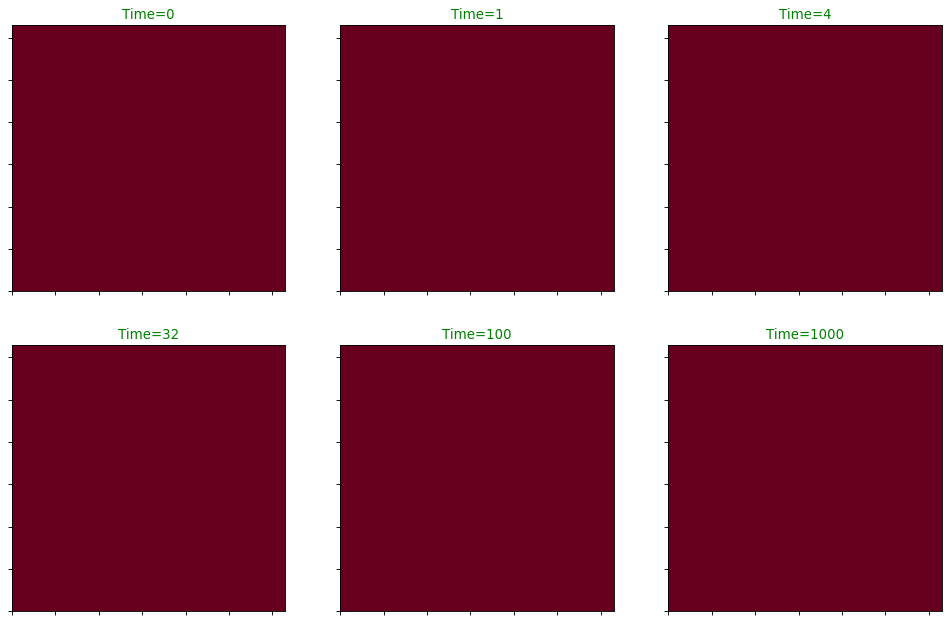

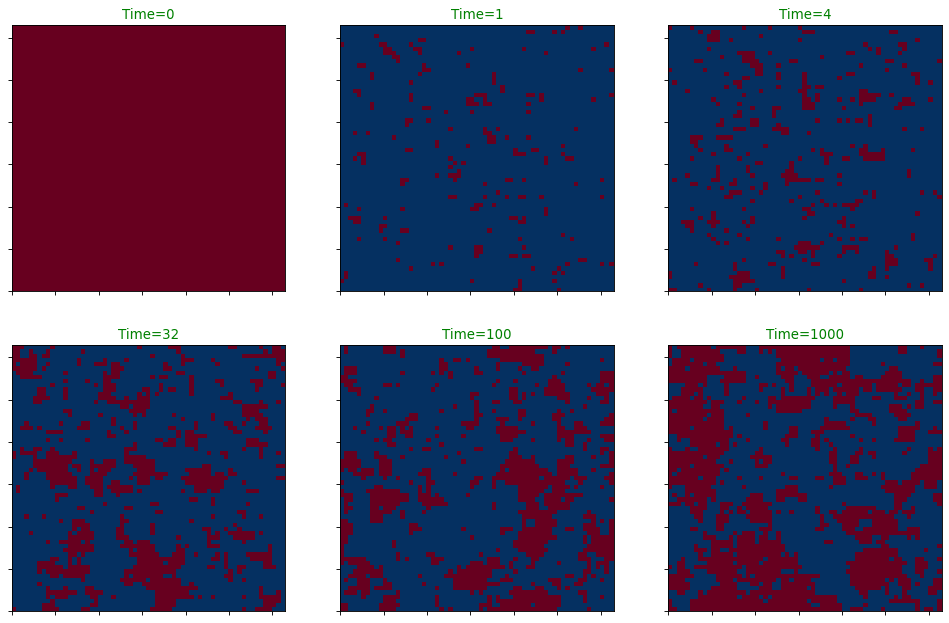

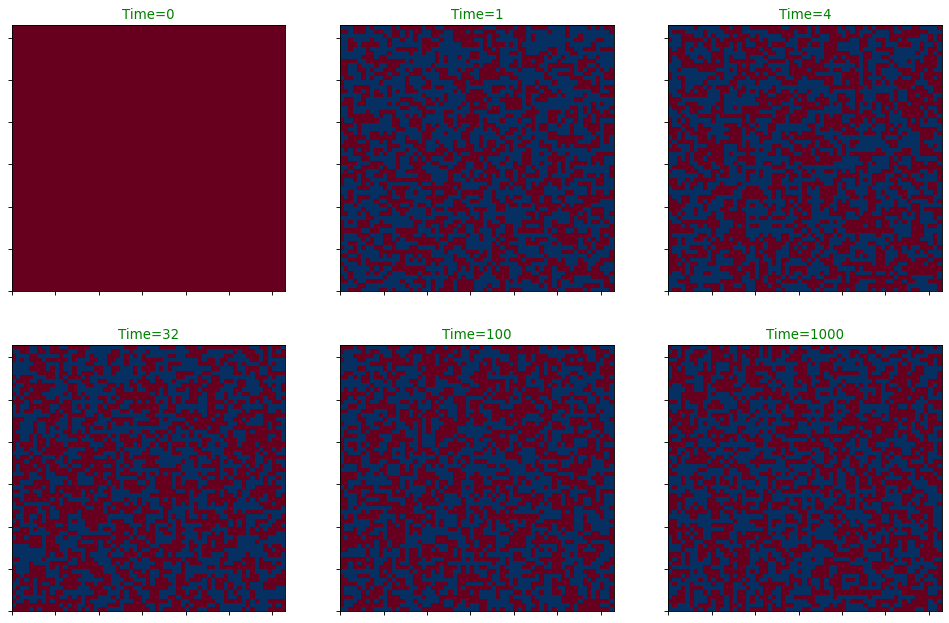

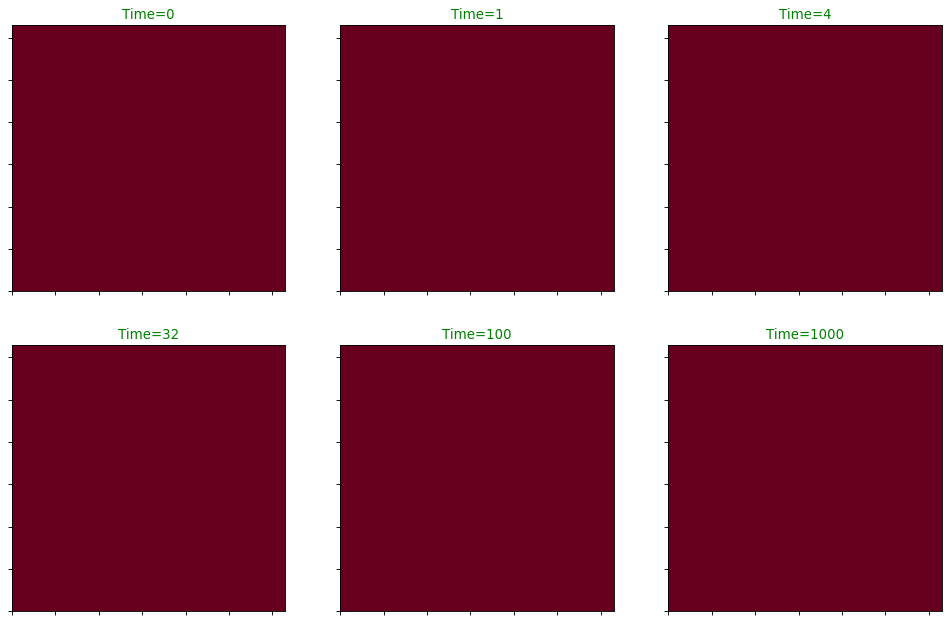

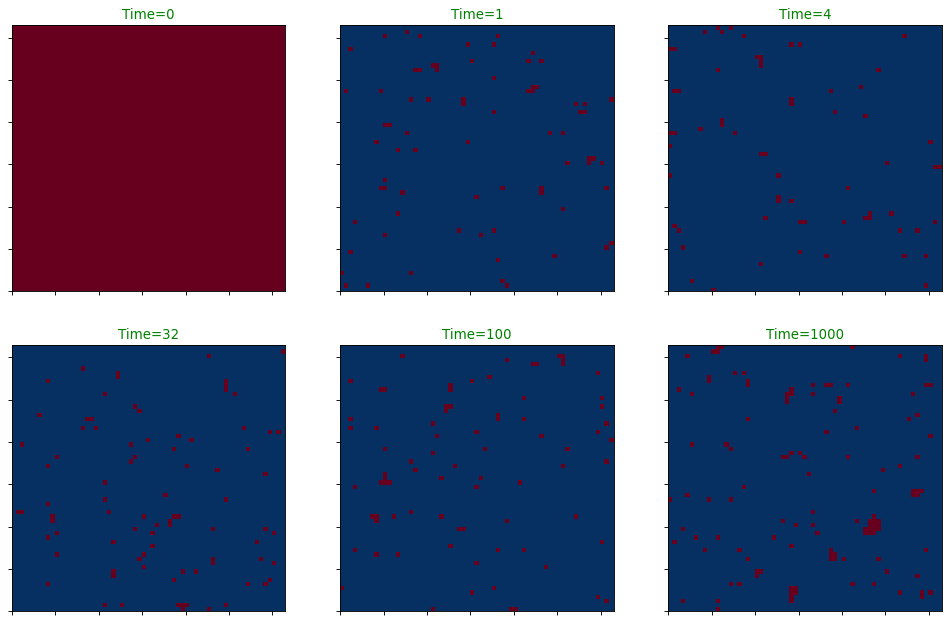

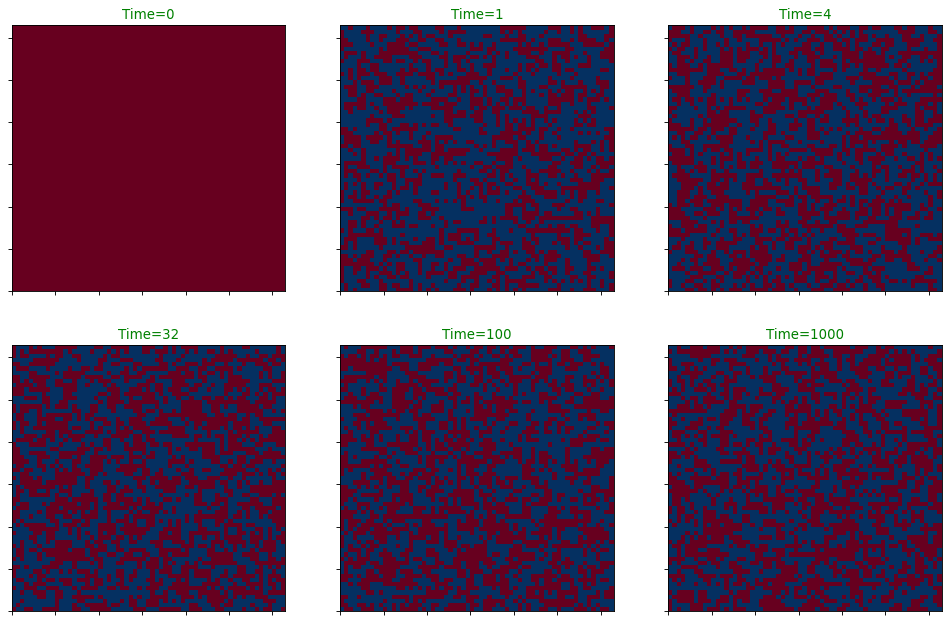

In [12]:
J =1

class Ising2D_nnb():
    ''' Simulating the Ising model '''    
    ## monte carlo moves
    def nnbmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):            
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    s =  config[a, b]
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    nnb1 = config[(a+1)%N,(b+1)%N] + config[(a+1)%N,(b-1)%N] + config[(a-1)%N,(b+1)%N] + config[(a-1)%N,(b-1)%N]
                    nnb2 = config[(a+2)%N,b] + config[a,(b+2)%N] + config[(a-2)%N,b] + config[a,(b-2)%N]
                    cost = 2*s*nb*J + 2*s*nnb1*J/(np.power(np.sqrt(2),4)) + 2*s*nb*J/16
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    
    def simulate(self,Temp):   
        ''' This module simulates the Ising model'''
        N      = 64        # Initialse the lattice
        config = initialstate2(N)    # Change cold / hot start above
        f = plt.figure(figsize=(15, 15), dpi=80); 
        self.configPlot(f, config, 0, N, 1)
        
        msrmnt = 1001
        for i in range(msrmnt):
            self.nnbmove(config, N, 1.0/Temp)
            if i == 1:       self.configPlot(f, config, i, N, 2)
            if i == 4:       self.configPlot(f, config, i, N, 3)
            if i == 32:      self.configPlot(f, config, i, N, 4)
            if i == 100:     self.configPlot(f, config, i, N, 5)
            if i == 1000:    self.configPlot(f, config, i, N, 6)
                 
                    
    def configPlot(self, f, config, i, N, n_):

        X, Y = np.meshgrid(range(N), range(N))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu)
        plt.title('Time=%d'%i, color = "g"); plt.axis('tight')    

rm = Ising2D()
rmnnb = Ising2D_nnb()
rm.simulate(0.3)
rm.simulate(2.5)
rm.simulate(10)
rmnnb.simulate(0.3)
rmnnb.simulate(2.5)
rmnnb.simulate(10)